<a href="https://colab.research.google.com/github/nhuarancay/Lasso-Regression-with-Gurobi/blob/main/01_Lasso_Linear_Regression_Gurobi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lasso Linear Regression in Gurobi

#### Modules

In [1]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

In [3]:
# Linear model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
# Preprocessiong to scale data
from sklearn.preprocessing import StandardScaler
# Matplotlib
import matplotlib.pyplot as plt
# Time
from time import time
%matplotlib inline

## Data

In [4]:
# Loading Training/Test data
df_train = pd.read_csv('training_data.csv')
df_test = pd.read_csv('test_data.csv')

In [5]:
# Training set columns
df_train.columns

Index(['y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50'],
      dtype='object')

In [6]:
# Test set columns
df_test.columns

Index(['y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50'],
      dtype='object')

# Linear Regression

### Linear Regression formula:

$$ y = \beta_0 + \beta_1x_{1} + ... + \beta_1x_{p} + \epsilon $$

### Solution Formulation - Linear Regression:

$$ \min_{\beta} \; \sum_{i=1}^{n} (\beta_0 + \beta_1x_{i1} + ... + \beta_1x_{ip} \; - \; y_i)^2 $$

$$ \text{Matrix notation:} $$

$$ \min_{\beta} \; \beta^\mathsf{T}(\mathbf{X}^\mathsf{T} \mathbf{X})\beta -2\beta^\mathsf{T} \mathbf{X}^\mathsf{T} \mathbf{y} + \mathbf{y}^\mathsf{T} \mathbf{y} $$

### General Quadratic Programming Formulation (QP):

$$ \min_{x} \;\;  \mathbf{x}^\mathsf{T} \mathbf{Q} \; \mathbf{x} \; + \; \mathbf{c}^\mathsf{T} \mathbf{x} \; + \; \mathbf{constant} $$

$$ \text{subject to:} \;\; \mathbf{A}^\mathsf{T} \mathbf{x} \leq \mathbf{b} $$

The Linear Regression Solution can be addressed as a QP model, where:

$$ \mathbf{x} = \beta \;\; \text{;} \;\; 
\mathbf{Q} = \mathbf{X}^\mathsf{T} \mathbf{X} \;\; \text{;} \;\;
\mathbf{c} = -2 \mathbf{X}^\mathsf{T} \mathbf{y} \;\; \text{;} \;\;
\mathbf{constant} = \mathbf{y}^\mathsf{T} \mathbf{y} $$

In [7]:
# Setting X matrices and y vectors
#----------------------------------------------------------------------
# Training
y = df_train['y'].copy()
X = df_train.loc[:,df_train.columns!='y'].copy()
X.insert(loc=0, column='constant', value=1) # add constant (β0)

# Test
y_test = df_test['y']
X_test = df_test.loc[:,df_train.columns!='y']
X_test.insert(loc=0, column='constant', value=1) # add constant (β0)

In [8]:
# QP Parameters
#----------------------------------------------------------------------
# number of betas
m = len(X.columns)

# Creating QP inputs
Q = X.T @ X       # Quadratic matrix (Q)
c = -2*X.T @ y    # Linear matrix (c)
const = y.T @ y   # constant

# Inputs
#----------------------------------------------------------------------
ndv   = m            # number of Decision Variables
vtype = ['C']*m      # Variable Types (all betas are continuos)
lb    = [-np.inf]*m  # Lower Bounds (betas can be positive or negative)

In [9]:
# Optimization for Linear Regression (no constraints)
#----------------------------------------------------------------------
lrMod = gp.Model()
lrMod_x = lrMod.addMVar(ndv,vtype=vtype,lb=lb)
lrMod.setMObjective(Q,c,const,sense=gp.GRB.MINIMIZE) # β'(X'X)β - 2 β'(X'y) + y'y
lrMod.Params.OutputFlag = 0
lrMod.Params.TIME_LIMIT = 300 # TIME LIMIT
lrMod.optimize()
print('Objective value: {:.5f}'.format(lrMod.objVal))

Restricted license - for non-production use only - expires 2024-10-28
Objective value: 523.01496


In [10]:
# Betas
betas_opt = lrMod.x

# Predictions
y_pred_test = X_test @ betas_opt
y_pred = X @ betas_opt

# Metrics
sse_test = ((y_pred_test - y_test)**2).sum()
sse_train = ((y_pred - y)**2).sum()

r2_test = pd.DataFrame({'y_pred_test':y_pred_test,'y_test':y_test}).corr().iloc[0,1]**2
r2_train = pd.DataFrame({'y_pred':y_pred,'y':y}).corr().iloc[0,1]**2

In [11]:
# Printing out Metrics
print('\033[1mTraining\033[0m')
print('SSE       : {:.2f}'.format(sse_train))
print('R-Squared : {:.2%}'.format(r2_train))
print('\033[1mTest\033[0m')
print('SSE       : {:.2f}'.format(sse_test))
print('R-Squared : {:.2%}'.format(r2_test))

Training
SSE       : 523.01
R-Squared : 89.36%
Test
SSE       : 115.38
R-Squared : 86.66%


In [12]:
# Coefficients:
#----------------------------------------------------------------------
print('Intercept   : {}'.format(betas_opt[0]))
print('Coefficients:')
np.array(betas_opt[1:])

Intercept   : 0.9618199706768854
Coefficients:


array([-0.03124313,  0.10830046,  0.33658635,  0.34788706, -0.07805158,
       -0.26870205,  0.56917466, -0.09265014, -2.80170764,  0.5961224 ,
        0.00342708, -0.40802441,  0.64028772,  0.34250235, -0.35811603,
       -0.22662545,  0.47574886,  0.61818724,  0.5627165 ,  0.91343131,
        0.1266948 , -0.44072877, -1.13218924,  0.71016955,  0.08281624,
       -1.48717747,  0.02439235, -0.38572888,  0.35864434,  0.08111228,
       -0.18165492,  0.74866389, -0.04257738,  1.2137678 , -0.53326153,
        0.23934142,  0.25972978, -0.13112438, -1.09826371,  0.45402031,
       -0.59555224,  0.33959881, -0.4208102 ,  0.04031396,  1.8661944 ,
       -0.01828012,  1.07420755,  0.147014  ,  0.56919769, -0.22109118])

# Lasso Regression

## Lasso scikit-learn

In [13]:
# Setting X matrices and y vectors
#---------------------------------------------------------------------
# Training
y = df_train['y'].copy()
X = df_train.loc[:,df_train.columns!='y'].copy()

# Test
y_test = df_test['y'].copy()
X_test = df_test.loc[:,df_train.columns!='y'].copy()

#### Optimal Lambda  $\lambda$ 

In [14]:
# Lasso CV with Normalized X train
modelcv = make_pipeline(StandardScaler(), LassoCV(cv=10)).fit(X, y)

In [15]:
# Optimal Lambda 𝜆
bestlambda = modelcv['lassocv'].alpha_
print('Optimal 𝜆: {}'.format(bestlambda))

Optimal 𝜆: 0.08471942409934509


In [16]:
# Lasso using Best Lambda with Normalized X train on the Entire Training set
model = make_pipeline(StandardScaler(), Lasso(alpha=bestlambda)).fit(X, y)

In [17]:
# Coefficients
print('Intercept   : {}'.format(model['lasso'].intercept_))
print('Coefficients:')
model['lasso'].coef_

Intercept   : 1.2762324862184158
Coefficients:


array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.71982685,  0.        ,
       -0.05745334, -0.        , -0.        , -0.        , -0.39585533,
       -0.23276644,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.22180365, -1.15847952,  0.77569425, -0.        ,
       -1.27950133,  0.        ,  0.        ,  0.06530332,  0.        ,
       -0.        ,  0.        , -0.10847216,  0.25740072,  0.01277731,
        0.        ,  0.        ,  0.        , -0.18839793,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.0186891 ,  1.63196351,
       -0.01838965,  0.69384574, -0.08473514,  0.        ,  0.        ])

In [18]:
# Number of non-zero coefficients
sum([1 for i in model['lasso'].coef_ if i!=0])

18

In [19]:
# Betas
betas_opt = model['lasso'].coef_

# Predictions
y_pred_test = X_test @ betas_opt + model['lasso'].intercept_
y_pred = X @ betas_opt + model['lasso'].intercept_

# Metrics
sse_test = ((y_pred_test - y_test)**2).sum()
sse_train = ((y_pred - y)**2).sum()

r2_test = pd.DataFrame({'y_pred_test':y_pred_test,'y_test':y_test}).corr().iloc[0,1]**2
r2_train = pd.DataFrame({'y_pred':y_pred,'y':y}).corr().iloc[0,1]**2

In [20]:
# Printing out Metrics
print('\033[1mTraining\033[0m')
print('SSE       : {:.2f}'.format(sse_train))
print('R-Squared : {:.2%}'.format(r2_train))
print('\033[1mTest\033[0m')
print('SSE       : {:.2f}'.format(sse_test))
print('R-Squared : {:.2%}'.format(r2_test))

Training
SSE       : 758.57
R-Squared : 85.88%
Test
SSE       : 132.10
R-Squared : 84.23%


## Lasso with Optimization (Gurobi)

### Solution Formulation - Lasso Linear Regression:

$$ \min_{\beta} \; \sum_{i=1}^{n} (\beta_0 + \beta_1x_{i1} + ... + \beta_1x_{ip} \; - \; y_i)^2 + \sum_{j=1}^{m} \lambda_j \lvert{\beta_j}\rvert $$

$$ \text{Matrix notation:} $$

$$ \min_{\beta} \; \beta^\mathsf{T}(\mathbf{X}^\mathsf{T} \mathbf{X})\beta -2\beta^\mathsf{T} \mathbf{X}^\mathsf{T} \mathbf{y} + \mathbf{y}^\mathsf{T} \mathbf{y} + \lambda \lvert{\beta}\rvert $$

$$ \text{where:} $$

$$ \lambda = \mbox{lambda vector} $$
$$ \lambda_1 = 0 , \; \text{the penalization doesn´t affect the intercept}  $$
$$ \lambda_{j \neq 1} = l_{1} \text{ penalization (alpha)} $$

However, it's difficult to solve the former formulation since that QP problem doesn´t meet the same form that the General QP formula because $\lvert{\beta}\rvert$ is a not linear and we cannot a proper form for $\mathbf{c}$.

We can linearize the problem with the following formulation:

## Lasso Formulation with the General QP form

Let's: $ \; \; \beta = \beta^+ - \beta^- $

where: <br>
$ \;\;\;\;\;\;\;\;\;\; \beta^+ : $ positive betas <br>
$ \;\;\;\;\;\;\;\;\;\; \beta^- : $ negative betas <br>

and: <br>

$
\;\;\;\;\;\;\;\;\;\; \beta^+ = \left\{
    \begin{array}\\
        \lvert \beta \rvert & \mbox{if } \ \beta > 0 \\
        0 & \mbox{else.}
    \end{array}
\right.
$

$
\;\;\;\;\;\;\;\;\;\; \beta^- = \left\{
    \begin{array}\\
        \lvert \beta \rvert & \mbox{if } \ \beta < 0 \\
        0 & \mbox{else.}
    \end{array}
\right.
$

## Formulation

$$ 
\min_{\beta^+, \beta^-} \; 
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}^\mathsf{T} 
\begin{pmatrix} +\mathbf{X}^\mathsf{T} \mathbf{X} & -\mathbf{X}^\mathsf{T} \mathbf{X} \\ -\mathbf{X}^\mathsf{T} \mathbf{X} & +\mathbf{X}^\mathsf{T} \mathbf{X} \end{pmatrix}
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}
+
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}^\mathsf{T} 
\begin{pmatrix} -2\mathbf{X}^\mathsf{T} \mathbf{y} \\ +2\mathbf{X}^\mathsf{T} \mathbf{y} \end{pmatrix}
+
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}^\mathsf{T} 
\begin{pmatrix} \lambda \\ \lambda \end{pmatrix}
+
\mathbf{y}^\mathsf{T} \mathbf{y}
$$
$$ \text{_________________________________________________} $$

$$ 
\min_{\beta^+, \beta^-} \; 
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}^\mathsf{T} 
\begin{pmatrix} +\mathbf{X}^\mathsf{T} \mathbf{X} & -\mathbf{X}^\mathsf{T} \mathbf{X} \\ -\mathbf{X}^\mathsf{T} \mathbf{X} & +\mathbf{X}^\mathsf{T} \mathbf{X} \end{pmatrix}
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}
+
\begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix}^\mathsf{T} 
\begin{pmatrix} \lambda-2\mathbf{X}^\mathsf{T} \mathbf{y} \\ \lambda+2\mathbf{X}^\mathsf{T} \mathbf{y} \end{pmatrix}
+
\mathbf{y}^\mathsf{T} \mathbf{y}
$$

$$ \text{subject to:} $$
$$ \begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix} \geq 0 $$

Now, for the Lasso Regression the parameters in the QP model are:

$$ \mathbf{x} = \begin{pmatrix} \beta^+ \\ \beta^- \end{pmatrix} \;\; \text{;} \;\; 
\mathbf{Q} = \begin{pmatrix} +\mathbf{X}^\mathsf{T} \mathbf{X} & -\mathbf{X}^\mathsf{T} \mathbf{X} \\ -\mathbf{X}^\mathsf{T} \mathbf{X} & +\mathbf{X}^\mathsf{T} \mathbf{X} \end{pmatrix} \;\; \text{;} \;\;
\mathbf{c} = \begin{pmatrix} \lambda-2\mathbf{X}^\mathsf{T} \mathbf{y} \\ \lambda+2\mathbf{X}^\mathsf{T} \mathbf{y} \end{pmatrix} \;\; \text{;} \;\;
\mathbf{constant} = \mathbf{y}^\mathsf{T} \mathbf{y} $$

Now, we should note that in Gurobi it would be indistintive 

### Formulation Lasso MIQP:

$$ \min_{\beta^{+}, \beta^{-}, z} \; 
\begin{pmatrix}\beta^{+}\\\beta^{-}\\\mathbf{z}\end{pmatrix}^\mathsf{T} 
\begin{pmatrix}+\mathbf{X}^\mathsf{T}\mathbf{X}&-\mathbf{X}^\mathsf{T}\mathbf{X}&0\\-\mathbf{X}^\mathsf{T}\mathbf{X}&+\mathbf{X}^\mathsf{T}\mathbf{X}&0\\0&0&0\end{pmatrix}
\begin{pmatrix}\beta^{+}\\\beta^{-}\\\mathbf{z}\end{pmatrix} 
+ \begin{pmatrix}\beta^{+}\\\beta^{-}\\\mathbf{z}\end{pmatrix}^\mathsf{T}  \begin{pmatrix}\lambda - 2\mathbf{X}^\mathsf{T}\mathbf{y}\\ \lambda + 2\mathbf{X}^\mathsf{T}\mathbf{y} \\ 0 \end{pmatrix}
+ \mathbf{y}^\mathsf{T}\mathbf{y} $$

$$ \text{subject to:} $$
$$ \beta^{+}_{i} - Mz_i \;\;\;\;\;\;\;\;\; \leq 0 $$
$$ \beta^{-}_{i} - M(1-z_i) \leq 0 $$

$$ \text{where:} $$
$$ \beta^{+} \geq 0 \; \; ; \; \; \beta^{+}: \text{positive betas} $$
$$ \beta^{-} \geq 0 \; \; ; \; \; \beta^{-}: \text{negative betas} $$
$$ z_i: \text{ binary, 1 if } \beta^{+}_{i} > 0 \text{, and 0 if } \beta^{-}_{i} \geq 0 $$
$$ M: \text{big number} $$

Then, the Lasso parameters in the QP model in Gurobi are:

$$ \mathbf{x} = \begin{pmatrix}\beta^{+}\\\beta^{-}\\\mathbf{z}\end{pmatrix} \;\; \text{;} \;\; 
\mathbf{Q} = \begin{pmatrix}+\mathbf{X}^\mathsf{T}\mathbf{X}&-\mathbf{X}^\mathsf{T}\mathbf{X}&0\\-\mathbf{X}^\mathsf{T}\mathbf{X}&+\mathbf{X}^\mathsf{T}\mathbf{X}&0\\0&0&0\end{pmatrix} \;\; \text{;} \;\;
\mathbf{c} = \begin{pmatrix} \lambda-2\mathbf{X}^\mathsf{T} \mathbf{y} \\ \lambda+2\mathbf{X}^\mathsf{T} \mathbf{y} \\ 0 \end{pmatrix} \;\; \text{;} \;\;
\mathbf{constant} = \mathbf{y}^\mathsf{T} \mathbf{y} $$

Adjusting for the factor as scikit-learn:

$$ 
factor = \dfrac{1}{2n} \;\; \text{;} \;\;
\mathbf{Q} = \mathbf{Q}*factor \;\; \text{;} \;\;
\mathbf{c} = \begin{pmatrix} \lambda-2\mathbf{X}^\mathsf{T} \mathbf{y}*factor \\ \lambda+2\mathbf{X}^\mathsf{T} \mathbf{y}*factor \\ 0 \end{pmatrix} \;\; \text{;} \;\;
\mathbf{constant} = \mathbf{constant}*factor $$

In [21]:
bestlambda = bestlambda

In [22]:
# Setting X matrices and y vectors
#-------------------------------------------
# Training
y = df_train['y'].copy()
X = df_train.loc[:,df_train.columns!='y'].copy()
X = pd.DataFrame(StandardScaler().fit(X).transform(X),columns=X.columns) # Scaled X train
X.insert(loc=0, column='constant', value=1) # add constant (β0)

# Test
y_test = df_test['y']
X_test = df_test.loc[:,df_train.columns!='y']
X_test.insert(loc=0, column='constant', value=1) # add constant (β0)

In [23]:
# number of betas
w = len(X.columns)

# number of variables
p = len(X.columns) - 1

# Factor by number of rows (Check scikit-learn: 
# (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1 )
factor = (1/(2*len(X)))

# Creating adjusted QP input matrices for QP Lasso
Q = np.zeros((3*w,3*w))
Q[ :  w, :  w] =  (X.T @ X)  # Top-left
Q[ :  w,w:2*w] = -(X.T @ X)  # Top-right
Q[w:2*w, :  w] = -(X.T @ X)  # Bottom-left
Q[w:2*w,w:2*w] =  (X.T @ X)  # Bottom-right
Q = Q*factor

c = np.zeros(3*w)
c[ :  w] = -2*(X.T @ y) # Left
c[w:2*w] = +2*(X.T @ y) # Right
c = c*factor
# lambda doesn't affect the intercept
lambda_vector = np.array([0] + [bestlambda]*p + [0] + [bestlambda]*p) 
c[:2*w] = c[:2*w] + lambda_vector

const = (y.T @ y)*factor

In [24]:
# Inputs and Constraints
M = 999

# Constraints
A = np.zeros((2*w,3*w))
b = np.zeros(2*w)

# if beta_pos > 0 then beta_neg = 0, viceversa
for i in range(w):
    A[  i, [  i,2*w+i]] = [1,-M]  # beta_pos(i) <= z(i)*M      -->  1*beta_pos(i) - M*z(i) <= 0
    A[w+i, [w+i,2*w+i]] = [1, M]  # beta_neg(i) <= (1-z(i))*M  -->  1*beta_neg(i) + M*z(i) <= M
    b[w+i] = M
    
sense = ['<']*(2*w)

ndv = 3*w
vtype = ['C']*(2*w) + ['B']*w
lb = [0]*ndv

In [25]:
# Optimization with constraints
lassoMod = gp.Model()
lassoMod_x = lassoMod.addMVar(ndv,vtype=vtype,lb=lb)
lassoMod_con = lassoMod.addMConstr(A, lassoMod_x, sense, b)
lassoMod.setMObjective(Q,c,const,sense=gp.GRB.MINIMIZE)
lassoMod.Params.OutputFlag = 0 
lassoMod.optimize()
print('Objective value: {:.5f}'.format(lassoMod.objVal))

Objective value: 2.03375


In [26]:
# Betas (Intercept and Coefficients)
lasso_opt_intercept_ = lassoMod.x[0] - lassoMod.x[w]
lasso_opt_coef_ = np.array(lassoMod.x[1:w]) - np.array(lassoMod.x[w+1:2*w])

In [27]:
print('Intercept   : {}'.format(lasso_opt_intercept_))
print('Coefficients:')
lasso_opt_coef_

Intercept   : 1.2762324862184156
Coefficients:


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -2.72026664,  0.        ,
       -0.05748608,  0.        ,  0.        ,  0.        , -0.39591542,
       -0.23261353,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.22172381, -1.15843581,  0.77566809,  0.        ,
       -1.27950516,  0.        ,  0.        ,  0.06524581,  0.        ,
        0.        ,  0.        , -0.10843391,  0.25766849,  0.0124064 ,
        0.        ,  0.        ,  0.        , -0.18844625,  0.        ,
        0.        ,  0.        ,  0.        ,  0.01883393,  1.63217102,
       -0.01835748,  0.69404256, -0.08471231,  0.        ,  0.        ])

In [28]:
# Number of non-zero coefficients
sum([1 for i in lasso_opt_coef_ if i!=0])

18

In [29]:
# Setting X matrices and y vectors
#---------------------------------------------------------------------
# Training
y = df_train['y'].copy()
X = df_train.loc[:,df_train.columns!='y'].copy()

# Test
y_test = df_test['y'].copy()
X_test = df_test.loc[:,df_train.columns!='y'].copy()

In [30]:
# Betas
betas_opt = lasso_opt_coef_

# Predictions
y_pred_test = X_test @ betas_opt + lasso_opt_intercept_
y_pred = X @ betas_opt + lasso_opt_intercept_

# Metrics
sse_test = ((y_pred_test - y_test)**2).sum()
sse_train = ((y_pred - y)**2).sum()

r2_test = pd.DataFrame({'y_pred_test':y_pred_test,'y_test':y_test}).corr().iloc[0,1]**2
r2_train = pd.DataFrame({'y_pred':y_pred,'y':y}).corr().iloc[0,1]**2

In [31]:
# Printing out Metrics
print('\033[1mTraining\033[0m')
print('SSE       : {:.2f}'.format(sse_train))
print('R-Squared : {:.2%}'.format(r2_train))
print('\033[1mTest\033[0m')
print('SSE       : {:.2f}'.format(sse_test))
print('R-Squared : {:.2%}'.format(r2_test))

Training
SSE       : 758.64
R-Squared : 85.88%
Test
SSE       : 132.12
R-Squared : 84.23%


### Coefficients comparison

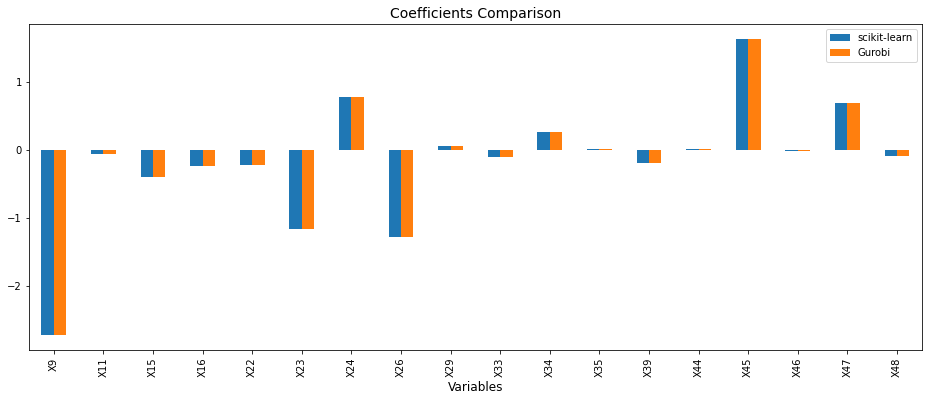

In [32]:
df_coefs = pd.DataFrame({'scikit-learn':model['lasso'].coef_,'Gurobi':lasso_opt_coef_}, index=X.columns)
df_coefs[df_coefs['Gurobi']!=0].plot(kind='bar', figsize=(16,6))
plt.title('Coefficients Comparison', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.show()

# Lasso Gurobi setting coefficients

In [ ]:
# Setting X matrices and y vectors
#-------------------------------------------
# Training
y = df_train['y'].copy()
X = df_train.loc[:,df_train.columns!='y'].copy()
X = pd.DataFrame(StandardScaler().fit(X).transform(X),columns=X.columns) # Scaled X train
X.insert(loc=0, column='constant', value=1) # add constant (β0)

# Test
y_test = df_test['y']
X_test = df_test.loc[:,df_train.columns!='y']
X_test.insert(loc=0, column='constant', value=1) # add constant (β0)

Let's set: $ \; \beta_9 = -2.5 $

In [34]:
# Inputs and Constraints
M = 999

# Constraints
A = np.zeros((2*w+1,3*w))
b = np.zeros(2*w+1)

# if beta_pos > 0 then beta_neg = 0, viceversa
for i in range(w):
    A[  i, [  i,2*w+i]] = [1,-M]  # beta_pos(i) <= z(i)*M      -->  1*beta_pos(i) - M*z(i) <= 0
    A[w+i, [w+i,2*w+i]] = [1, M]  # beta_neg(i) <= (1-z(i))*M  -->  1*beta_neg(i) + M*z(i) <= M
    b[w+i] = M
A[-1, [w+9]] = 1
b[-1] = 2.5

sense = ['<']*(2*w) + ['=']

ndv = 3*w
vtype = ['C']*(2*w) + ['B']*w
lb = [0]*ndv

In [35]:
# Optimization with constraints
lassoMod = gp.Model()
lassoMod_x = lassoMod.addMVar(ndv,vtype=vtype,lb=lb)
lassoMod_con = lassoMod.addMConstr(A, lassoMod_x, sense, b)
lassoMod.setMObjective(Q,c,const,sense=gp.GRB.MINIMIZE)
lassoMod.Params.OutputFlag = 0 
lassoMod.optimize()
print('Objective value: {:.5f}'.format(lassoMod.objVal))

Objective value: 2.04373


In [36]:
# Betas (Intercept and Coefficients)
lasso_opt_intercept_ = lassoMod.x[0] - lassoMod.x[w]
lasso_opt_coef_ = np.array(lassoMod.x[1:w]) - np.array(lassoMod.x[w+1:2*w])

In [37]:
print('Intercept   : {}'.format(lasso_opt_intercept_))
print('Coefficients:')
lasso_opt_coef_

Intercept   : 1.2762324862184156
Coefficients:


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -2.5       ,  0.        ,
       -0.06027474,  0.        ,  0.        ,  0.        , -0.38019428,
       -0.27117309,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.25134667, -1.14402368,  0.7965625 ,  0.        ,
       -1.29560821,  0.        ,  0.        ,  0.11115918,  0.        ,
        0.        ,  0.        , -0.12660695,  0.20769114,  0.12766113,
        0.        ,  0.        ,  0.        , -0.14257385,  0.        ,
        0.        ,  0.00753995,  0.        ,  0.        ,  1.56089293,
       -0.03122018,  0.61232963, -0.08997893,  0.        ,  0.        ])

In [38]:
# Setting X matrices and y vectors
#---------------------------------------------------------------------
# Training
y = df_train['y'].copy()
X = df_train.loc[:,df_train.columns!='y'].copy()

# Test
y_test = df_test['y'].copy()
X_test = df_test.loc[:,df_train.columns!='y'].copy()

In [39]:
# Betas
betas_opt = lasso_opt_coef_

# Predictions
y_pred_test = X_test @ betas_opt + lasso_opt_intercept_
y_pred = X @ betas_opt + lasso_opt_intercept_

# Metrics
sse_test = ((y_pred_test - y_test)**2).sum()
sse_train = ((y_pred - y)**2).sum()

r2_test = pd.DataFrame({'y_pred_test':y_pred_test,'y_test':y_test}).corr().iloc[0,1]**2
r2_train = pd.DataFrame({'y_pred':y_pred,'y':y}).corr().iloc[0,1]**2

In [40]:
# Printing out Metrics
print('\033[1mTraining\033[0m')
print('SSE       : {:.2f}'.format(sse_train))
print('R-Squared : {:.2%}'.format(r2_train))
print('\033[1mTest\033[0m')
print('SSE       : {:.2f}'.format(sse_test))
print('R-Squared : {:.2%}'.format(r2_test))

Training
SSE       : 719.21
R-Squared : 86.23%
Test
SSE       : 122.80
R-Squared : 85.19%


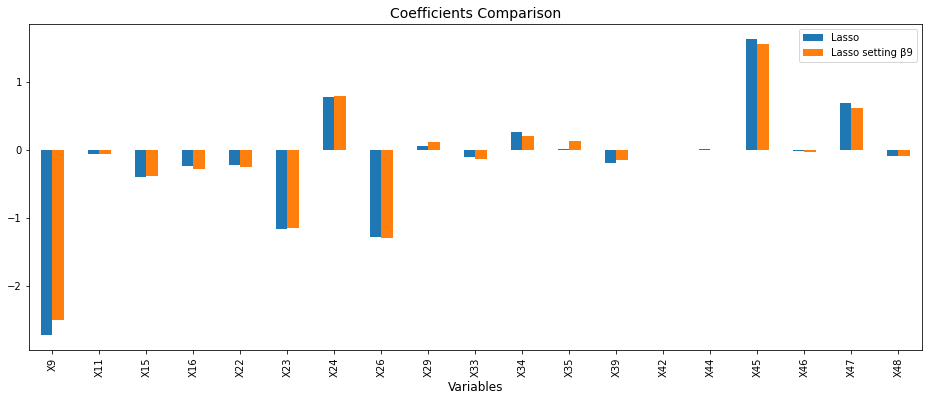

In [42]:
df_coefs = pd.DataFrame({'Lasso':model['lasso'].coef_,'Lasso setting β9':lasso_opt_coef_}, index=X.columns)
df_coefs_betas = df_coefs[(df_coefs['Lasso setting β9']!=0)|(df_coefs['Lasso']!=0)]
df_coefs_betas.plot(kind='bar', figsize=(16,6))
plt.title('Coefficients Comparison', fontsize=14)
plt.xlabel('Variables', fontsize=12)
plt.show()